# Bayesian Machine Learning
## Challenges in Markov chain Monte Carlo for Bayesian neural networks

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from typing import Union
from tqdm import tqdm

sys.path.append('../source/')
from utils import effective_sample_size
from HMC import HMC
from MALA import MALA, AdaptiveMALA
from RWHM import Metropolis_Hastings
from model import Model
from utils import effective_sample_size, gelman_rubin

### Utils

In [2]:
def log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        log_target_array = log_target_tensor.cpu().detach().numpy()
        return log_target_array
        
    return log_target_fn

In [3]:
def grad_log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def grad_log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        grad_tensor = mlp.compute_grad_log_target(log_target_tensor)
        grad_array = grad_tensor.cpu().detach().numpy()
        return grad_array

    return grad_log_target_fn

In [4]:
def diagnostic_MCMC(samples):
    ess = 0.0
    for i in range(samples.shape[0]):
        ess += effective_sample_size(samples[i])
    ess /= samples.shape[0]
    R_hat = gelman_rubin(samples)
    return ess, R_hat


In [10]:
def run(
    sizes,
    activations,
    X_train,
    y_train,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    mh_params=dict(sigma_prop=None),
    hmc_params=dict(step_size=0.00004, n_leapfrog=10),
    mala_params=dict(step_size=None),
    sala_params=dict(step_size=None),
):
    samples_to_consider = (N_steps - N_burnin) // 10


    mlp = Model(sizes, activations)
    print(mlp)

    log_target_fn = log_target_factory(mlp, X_train, y_train)
    grad_log_target_fn = log_target_factory(mlp, X_train, y_train)

    N_params = mlp.num_parameters()
    mu = np.zeros(N_params)
    sigma =  10 * np.ones(N_params)
    def prior(size):
        return np.random.multivariate_normal(mean=mu, cov=np.diag(sigma), size=size)
    
    theta_0 = prior(1)[0]
    
    print("_Symmetric_Random_Walk_Metropolis_Hastings_".center(100).replace(" ", "=").replace("_", " "))
    MH_sampler = Metropolis_Hastings(
        log_target=log_target_fn, theta_0=theta_0, **mh_params
    )
    sample = np.zeros((5, N_steps-N_burnin+1, N_params))
    for i,seed in enumerate(range(40,45)):
        np.random.seed(seed)
        sample[i], _ = MH_sampler.sample(N_steps, N_burnin, verbose=verbose, return_burn_in=False)
        
    ess, R_hat = diagnostic_MCMC(sample)
    print(f"\tEffective sample size: {ess}")
    print(f"\tPSRF: {R_hat}")
    print("\n")
    
    print("_Hamiltonian_Monte_Carlo_".center(100).replace(" ", "=").replace("_", " "))
    HMC_sampler = HMC(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **hmc_params
    )
    sample = np.zeros((5, N_steps-N_burnin+1, N_params))
    for i,seed in enumerate(range(40,45)):
        np.random.seed(seed)
        sample[i], _ = HMC_sampler.sample(N_steps, N_burnin, verbose=verbose, return_burn_in=False)
        
    ess, R_hat = diagnostic_MCMC(sample[:,samples_to_consider::, :])
    print(f"\tEffective sample size: {ess}")
    print(f"\tPSRF: {R_hat}")
    print("\n")

    
    print("_Adapative_MALA_".center(100).replace(" ", "=").replace("_", " "))
    SALA_sampler = AdaptiveMALA(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **sala_params
    )
    sample = np.zeros((5, N_steps-N_burnin+1, N_params))
    for i,seed in enumerate(range(40,45)):
        np.random.seed(seed)
        sample[i], _ = SALA_sampler.sample(N_steps, N_burnin, verbose=verbose, return_burn_in=False)
        
    ess, R_hat = diagnostic_MCMC(sample)
    print(f"\tEffective sample size: {ess}")
    print(f"\tPSRF: {R_hat}")
    print("\n")
    

### Noisy XOR

In [6]:
sizes_xor = [2, 2, 2]
activations_xor = [nn.ReLU(), nn.ReLU(), None]

#### Dataset 1

In [7]:
X_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/x.csv")
Y_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/y.csv")
X_noisy_xor_1 = X_noisy_xor_1.to_numpy()
Y_noisy_xor_1 = Y_noisy_xor_1.to_numpy(dtype=int).flatten()
X_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/x.csv")
Y_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/y.csv")
X_noisy_xor_1_test = X_noisy_xor_1_test.to_numpy()
Y_noisy_xor_1_test = Y_noisy_xor_1_test.to_numpy(dtype=int).flatten()

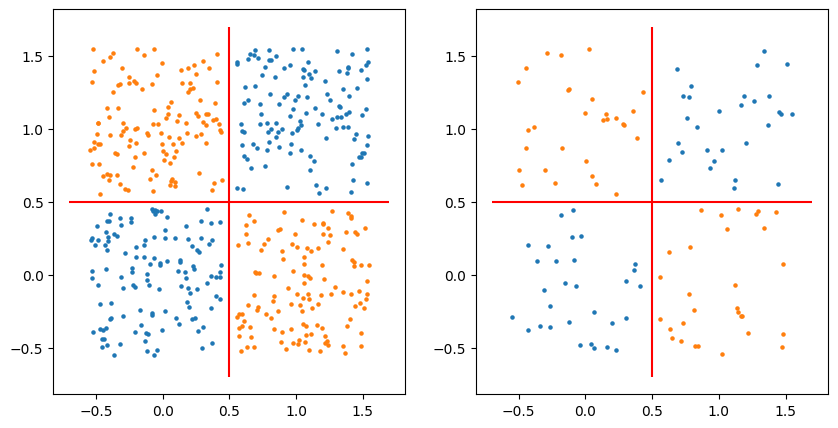

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy_xor_1[Y_noisy_xor_1==0, 0], X_noisy_xor_1[Y_noisy_xor_1==0, 1], s=5)
plt.scatter(X_noisy_xor_1[Y_noisy_xor_1==1, 0], X_noisy_xor_1[Y_noisy_xor_1==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.subplot(1, 2, 2)
plt.scatter(X_noisy_xor_1_test[Y_noisy_xor_1_test==0, 0], X_noisy_xor_1_test[Y_noisy_xor_1_test==0, 1], s=5)
plt.scatter(X_noisy_xor_1_test[Y_noisy_xor_1_test==1, 0], X_noisy_xor_1_test[Y_noisy_xor_1_test==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.show()

In [11]:
run(
    sizes=sizes_xor,
    activations=activations_xor,
    X_train=X_noisy_xor_1,
    y_train=Y_noisy_xor_1,
    N_steps=110_000,
    N_burnin=10_000,
)

Model(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
============================ Symmetric Random Walk Metropolis Hastings =============================


100%|██████████| 110000/110000 [03:37<00:00, 506.18it/s]


	Effective sample size: 232996.49985184072
	PSRF: (13.794162037470155+0j)


===================================== Hamiltonian Monte Carlo ======================================


 47%|████▋     | 51216/110000 [11:07<15:45, 62.17it/s] 

#### Dataset 2

In [ ]:
X_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/x.csv")
Y_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/y.csv")
X_noisy_xor_2 = X_noisy_xor_2.to_numpy()
Y_noisy_xor_2 = Y_noisy_xor_2.to_numpy(dtype=int).flatten()
X_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/x.csv")
Y_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/y.csv")
X_noisy_xor_2_test = X_noisy_xor_2_test.to_numpy()
Y_noisy_xor_2_test = Y_noisy_xor_2_test.to_numpy(dtype=int).flatten()

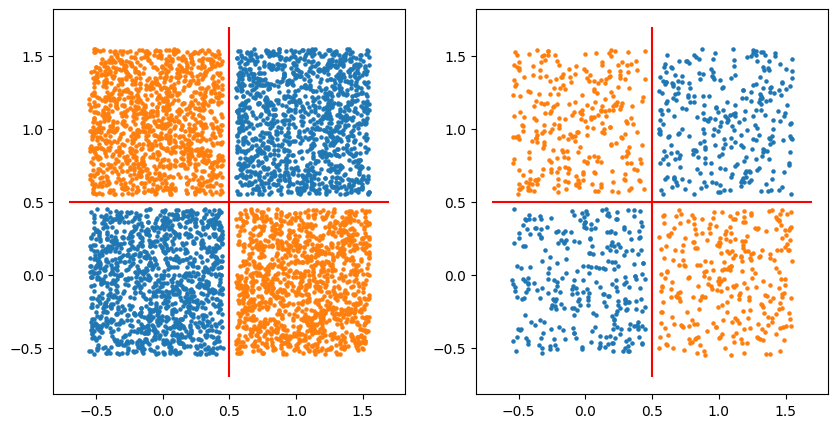

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy_xor_2[Y_noisy_xor_2==0, 0], X_noisy_xor_2[Y_noisy_xor_2==0, 1], s=5)
plt.scatter(X_noisy_xor_2[Y_noisy_xor_2==1, 0], X_noisy_xor_2[Y_noisy_xor_2==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.subplot(1, 2, 2)
plt.scatter(X_noisy_xor_2_test[Y_noisy_xor_2_test==0, 0], X_noisy_xor_2_test[Y_noisy_xor_2_test==0, 1], s=5)
plt.scatter(X_noisy_xor_2_test[Y_noisy_xor_2_test==1, 0], X_noisy_xor_2_test[Y_noisy_xor_2_test==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.show()

In [ ]:
run(
    sizes=sizes_xor,
    activations=activations_xor,
    X_train=X_noisy_xor_2,
    y_train=Y_noisy_xor_2,
    N_steps=110_000,
    N_burnin=10_000,
)

Model(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
============================ Symmetric Random Walk Metropolis Hastings =============================


100%|██████████| 110000/110000 [03:35<00:00, 509.84it/s]


	Effective sample size: [4.22483225 2.64951189 7.49637418 9.54724713 2.35249584 7.39177768
 3.62566399 9.33954445 4.34447822 7.24251873 9.91948022 9.00699495]
	PSRF: [3.19573845 5.77725902 6.39225181 4.61653743 3.15103825 6.49104547
 2.42502537 5.29423748 2.63380759 3.45334606 7.77123084 2.88668682]


===================================== Hamiltonian Monte Carlo ======================================


100%|██████████| 110000/110000 [11:35<00:00, 158.06it/s]
/home/hugo/Workspace/MVA/BayesianML/Project/VENV/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hugo/Workspace/MVA/BayesianML/Project/VENV/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/hugo/Workspace/MVA/BayesianML/Project/VENV/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/hugo/Workspace/MVA/BayesianML/Project/VENV/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


	Effective sample size: [nan nan nan nan nan nan nan nan nan nan nan nan]
	PSRF: [0.999995 0.999995 0.999995 0.999995 0.999995 0.999995 0.999995 0.999995
 0.999995 0.999995 0.999995 0.999995]


========================================== Adapative MALA ==========================================


100%|██████████| 110000/110000 [03:33<00:00, 515.88it/s]


	Effective sample size: [2.78839347 5.00987821 0.55885316 0.65496858 3.3052114  0.5534506
 4.46032361 2.16186902 2.95828647 1.49615703 1.18869455 1.35144891]
	PSRF: [1.60954188 1.96030881 1.11787098 1.08584803 1.56733076 1.09469739
 1.19567246 1.30323771 1.2243894  1.29846249 1.17673216 1.058089  ]




### Pima

#### Dataset 1

In [ ]:
X_pima_1 = pd.read_csv("../data/pima/data1/x.csv")
Y_pima_1 = pd.read_csv("../data/pima/data1/y.csv")
X_pima_1 = X_pima_1.to_numpy()
Y_pima_1 = Y_pima_1.to_numpy(dtype=int).flatten()
X_pima_1, X_pima_1_test, Y_pima_1, Y_pima_1_test = train_test_split(X_pima_1, Y_pima_1, test_size=0.4)

In [ ]:
run(
    sizes=[8, 2, 2, 2],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_pima_1,
    y_train=Y_pima_1,
    X_test=X_pima_1_test,
    y_test=Y_pima_1_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    sala_params=dict(step_size=2e-7),
    mala_params=dict(step_size=1e-7),
    n_params_to_plot=4,
)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=2, bias=True)
    (1-2): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
============================ Symmetric Random Walk Metropolis Hastings =============================


100%|██████████| 110000/110000 [01:47<00:00, 1020.32it/s]


KeyboardInterrupt: 

#### Dataset 2

In [ ]:
X_pima_2 = pd.read_csv("../data/pima/data2/x.csv")
Y_pima_2 = pd.read_csv("../data/pima/data2/y.csv")
X_pima_2 = X_pima_2.to_numpy()
Y_pima_2 = Y_pima_2.to_numpy(dtype=int).flatten()
X_pima_2, X_pima_2_test, Y_pima_2, Y_pima_2_test = train_test_split(X_pima_2, Y_pima_2, test_size=0.2)

In [ ]:
run(
    sizes=[4, 2, 2, 2],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_pima_2,
    y_train=Y_pima_2,
    N_steps=110_000,
    N_burnin=10_000,
)

### Penguins

In [ ]:
X_penguins = pd.read_csv("../data/penguins/x.csv")
X_penguins.drop(columns="year", inplace=True)
Y_penguins = pd.read_csv("../data/penguins/y.csv")
X_penguins = X_penguins.to_numpy()
Y_penguins = Y_penguins.to_numpy(dtype=int).flatten()
X_penguins, X_penguins_test, Y_penguins, Y_penguins_test = train_test_split(X_penguins, Y_penguins, test_size=0.2)

In [ ]:
run(
    sizes=[6, 2, 2, 3],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_penguins,
    y_train=Y_penguins,
    X_test=X_penguins_test,
    y_test=Y_penguins_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    hmc_params=dict(step_size=3e-5, n_leapfrog=10),
    sala_params=dict(step_size=2e-7),
    mala_params=dict(step_size=1e-7),
    n_params_to_plot=4,
)

### Hawks

In [ ]:
X_hawks = pd.read_csv("../data/hawks/x.csv")
Y_hawks = pd.read_csv("../data/hawks/y.csv")
X_hawks = X_hawks.to_numpy()
Y_hawks = Y_hawks.to_numpy(dtype=int).flatten()
X_hawks, X_hawks_test, Y_hawks, Y_hawks_test = train_test_split(X_hawks, Y_hawks, test_size=0.2)

In [ ]:
run(
    sizes=[6, 2, 2, 3],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_penguins,
    y_train=Y_penguins,
    N_steps=110_000,
    N_burnin=10_000,
)